In [94]:
import pickle, re, os, sys, json, time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import sentencepiece as spm
%matplotlib inline
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

from collections import Counter
from konlpy.tag import Okt, Mecab
from tqdm.notebook import tqdm

from wordcloud import WordCloud
from datetime import datetime
from dateutil.relativedelta import relativedelta

from root.utils.read_write_db import read
from root.utils.db_func import get_category_info, get_category_id_by_name, get_parent_category, get_category_tree, get_category_name
from root.utils.mysql import MySQL, get_db_info

In [95]:
from selenium import webdriver
from selenium.webdriver import ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait

In [96]:
presuffix_list = [
    '가격만족도 성능 사용편의성 등',
    '가격만족도성능사용편의성 등',
    '재구매횟수 또는 기간',
    '그 외 도움이 될 만한 사용후기',
    '상태 배송',
    '옥션 안드로이드 앱으로 작성',
    '마켓 안드로이드 앱에서 작성',
    '상태배송'
]

In [97]:
def get_inform_text(diff):
    category_name, count = diff
    if count > 0:
        return '{}({}개 증가)'.format(category_name, int(count))
    else:
        return '{}({}개 감소)'.format(category_name, int(abs(count)))

In [98]:
def clean_review(text):
    for presuffix in presuffix_list:
        text = text.replace(presuffix, '')
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!;』\\‘|\(\)\[\]\<\>`\'…》]', '', text).replace('\n', ' ').replace('\t', ' ').strip()
    if len(text):
        return text
    else:
        return np.nan

In [99]:
def get_tokens(review, tokenizer, use_tag=True):
    try:
        if use_tag:
            try:
                return [token for token, pos in tokenizer.pos(review, norm=True) if pos in tag_list]
            except:
                return [token for token, pos in tokenizer.pos(review) if pos in tag_list]
        else:
            return [token for token in tokenizer.morphs(review)]
    except:
        return []

In [100]:
def get_category_name_by_campaign_id(campaign_id, db = None):
    sql = "select c.liter_category from zeliterai.campaign c where c.liter_campaign_id = {}".format(campaign_id)
    result = db.execute(sql)[0]['liter_category']
    return result

In [101]:
def get_top_category_by_campaign_id(campaign_id, db=None):
    cat_dict = {85:'food',
               205:'cosmetics'}
    
    sql = "select cl.category_id from zeliterai.campaign c join zeliterai.category_language cl on c.liter_category = cl.name where c.liter_campaign_id = {}".format(campaign_id)
    category_id = db.execute(sql)
    if category_id:
        category_id = category_id[0]['category_id']
    else:
        raise Exception('category_id를 찾을 수 없습니다')
    
    parent_category_code = 'N'
    while parent_category_code:
        parent_category_code = get_category_tree(category_id)[0]['parent_id']
        if parent_category_code:
            category_id = parent_category_code
        elif category_id in cat_dict:
            return cat_dict[category_id]
        else:
            raise Exception('식품 또는 화장품이 아닙니다.')
            

In [102]:
host, db_name, user, password = get_db_info()
db = MySQL(host, db_name, user, password)

In [105]:
tokenizer = Mecab()
#tokenizer = Okt()

tag_list = ['NNG', 'NNB', 'NNP', 'VV', 'VA']    # 일반명사, 의존명사, 고유명사, 동사, 형용사
#tag_list = ['Noun', 'Verb', 'Adjective', 'Adverb']

In [107]:
font_path = '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf'
fontprop = fm.FontProperties(fname=font_path, size=5)

In [108]:
campaign_id = 40184
category_name = get_category_name_by_campaign_id(campaign_id, db)
category_id = get_category_id_by_name(category_name)
category_list = list(get_category_info(category_name))

In [109]:
condition = ['all', 'all', 'all', 'all']
critical_review_num = 1
min_review_length=1

In [110]:
now = datetime.now()
end_date = datetime(now.year, now.month, 1)
start_date = end_date + relativedelta(months=-6)

In [111]:
category_reviews = read(category_list, condition, critical_review_num, min_review_length, start_date, end_date)
category_reviews.drop_duplicates(subset=['product_name', 'content'], inplace=True)
category_reviews['content'] = category_reviews['content'].map(clean_review)
category_reviews.dropna(subset=['content'], inplace=True)

In [112]:
dataset = pd.read_excel('201203_1815_3M손소독제.xlsx')
dataset.dropna(inplace=True)
dataset['yearmonth'] = dataset.date.dt.strftime('%Y-%m')

In [113]:
corpus = []
for review in tqdm(dataset['리뷰'].values):
    corpus.append(get_tokens(review, tokenizer))

### Keyword Trend

In [153]:
def get_mean_vectors(subject_dict):
    mean_vector_dict = dict()
    for subject_name, keywords in subject_dict.items():
        vectors = list()
        if subject_name == '기타':
            continue
        for keyword in keywords:
            vectors.append(ft_model.wv.get_vector(keyword))
        mean_vector = np.asarray(vectors).mean(axis=0)
        mean_vector_dict[subject_name] = mean_vector
    return mean_vector_dict

def get_subject_review_dict(reviews, subject_review_dict):
    review_tokens = get_tokens(review, tokenizer)
    subjects = list()
    for word in review_tokens:
        true_index = ft_model.wv.cosine_similarities(ft_model.wv[word], np.asarray(list(mean_vector_dict.values()))) > 0.8
        subjects.extend(list(np.asarray(list(mean_vector_dict.keys()))[true_index]))
    for subject_name in set(subjects):
        subject_review_dict[subject_name] = subject_review_dict.get(subject_name, []) + [review]
    return subject_review_dict

In [154]:
category = get_top_category_by_campaign_id(campaign_id, db)

In [32]:
json_path = '키워드 추출/mecab_{}_dict.json'.format(category)
ft_model_path = '키워드 추출/ft_mecab_{}.pkl'.format(category)

In [ ]:
with open(json_path, 'r') as f:
    subject_dict = json.load(f)

In [ ]:
with open(ft_model_path, 'rb') as f:
    ft_model = pickle.load(f)
vocab = ft_model.wv.index2word

In [ ]:
mean_vector_dict = get_mean_vectors(subject_dict)

In [ ]:
category_reviews['yearmonth'] = category_reviews.created_at.dt.strftime('%Y-%m')

In [ ]:
total_count = list()
for month in tqdm(category_reviews['yearmonth'].unique()):
    subject_review_dict = dict()
    temp_data = category_reviews[category_reviews['yearmonth'] == month]
    for review in temp_data['content'].values:
        subject_review_dict = get_subject_review_dict(review, subject_review_dict)
    for subject, reviews in subject_review_dict.items():
        total_count.append([month, subject, len(reviews)])

In [ ]:
total_count = pd.DataFrame(total_count, columns=['month', 'subject_name', 'count'])

In [ ]:
min_month = total_count.month.min()
max_month = total_count.month.max()

In [ ]:
diff_df = pd.DataFrame([], index=subject_dict.keys())
diff_df = diff_df.join(total_count.loc[total_count['month'] == min_month].set_index('subject_name').drop('month', axis=1))
diff_df = diff_df.join(total_count.loc[total_count['month'] == max_month].set_index('subject_name').drop('month', axis=1), rsuffix='max')
diff_df.columns = ['min_month', 'max_month']
diff_df.fillna(0, inplace=True)
diff_df['diff'] = diff_df.max_month - diff_df.min_month

In [ ]:
diff_list = diff_df['diff'].reset_index().values.tolist()

In [ ]:
subject_trend = pd.DataFrame()
for month in sorted(total_count.month.unique()):
    temp = total_count[total_count['month'] == month].sort_values(by='count', ascending=False).iloc[:15]
    subject_trend = pd.concat([subject_trend, temp['subject_name'].rename(month).reset_index(drop=True)], axis=1)

In [ ]:
display(subject_trend)
print('{} 카테고리의 리뷰 중 지난 6개월 간 가장 언급량이 많이 늘어난 주제는 {}, 가장 많이 줄어든 주제는 {} 입니다.'.format(category_name, get_inform_text(max(diff_list, key=lambda x:x[1])), get_inform_text(min(diff_list, key=lambda x:x[1]))))

------

##### 구매결정요인 점수 트렌드

In [151]:
dataset['평점'] = dataset['rating']
del dataset['rating']

In [ ]:
factor_colnames = list(dataset.columns.drop(['리뷰', 'date', '평점', 'yearmonth']))

In [ ]:
# map_dict = {1:1, 2:3, 3:5}
map_dict = {1:1, 3:5}
for colname in factor_colnames:
    dataset[colname] = dataset[colname].map(map_dict)

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(data=dataset.groupby('yearmonth')[['평점',] + factor_colnames].mean())
plt.show()

### 네이버 카테고리 인기검색어

In [155]:
client_id = '_o_e_RVsRYAi2t27Pi6z'
client_secret = 'tI0kN6fFpN'

In [156]:
parent_category = get_parent_category(category_id)
parent_tree = get_category_tree(parent_category['id'])
parent_tree

({'id': 556, 'parent_id': 491},
 {'id': 557, 'parent_id': 556},
 {'id': 558, 'parent_id': 556},
 {'id': 559, 'parent_id': 556},
 {'id': 560, 'parent_id': 556},
 {'id': 561, 'parent_id': 556},
 {'id': 562, 'parent_id': 556},
 {'id': 563, 'parent_id': 556})

In [157]:
import urllib.request
url = "https://openapi.naver.com/v1/datalab/shopping/category/keywords"
body = '{"startDate":"2020-06-01","endDate":"2020-11-30","timeUnit":"week","category":"50000155","keyword":[' \
       '{"name" : "반려동물", "param": ["달미펫"]},' \
       '{"name" : "반려동물", "param": ["페스룸"]}' \
       ']}'

rq = urllib.request.Request(url)
rq.add_header("X-Naver-Client-Id",client_id)
rq.add_header("X-Naver-Client-Secret",client_secret)
rq.add_header("Content-Type","application/json")
response = urllib.request.urlopen(rq, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
else:
    print("Error Code:" + rescode)

In [158]:
result = json.loads(response_body)['results']

In [159]:
json.loads(response_body)

{'startDate': '2020-06-01',
 'endDate': '2020-12-06',
 'timeUnit': 'week',
 'results': [{'title': '반려동물',
   'keyword': ['페스룸'],
   'data': [{'period': '2020-06-01', 'ratio': 73.97097},
    {'period': '2020-06-08', 'ratio': 78.34879},
    {'period': '2020-06-15', 'ratio': 70.87794},
    {'period': '2020-06-22', 'ratio': 75.16059},
    {'period': '2020-06-29', 'ratio': 92.0295},
    {'period': '2020-07-06', 'ratio': 83.84487},
    {'period': '2020-07-13', 'ratio': 78.18225},
    {'period': '2020-07-20', 'ratio': 77.80157},
    {'period': '2020-07-27', 'ratio': 85.17725},
    {'period': '2020-08-03', 'ratio': 83.86866},
    {'period': '2020-08-10', 'ratio': 83.20247},
    {'period': '2020-08-17', 'ratio': 94.48013},
    {'period': '2020-08-24', 'ratio': 96.40732},
    {'period': '2020-08-31', 'ratio': 100},
    {'period': '2020-09-07', 'ratio': 92.36259},
    {'period': '2020-09-14', 'ratio': 71.71068},
    {'period': '2020-09-21', 'ratio': 66.69045},
    {'period': '2020-09-28', 'ratio'

##### 카테고리 인기검색어 크롤링

In [160]:
from root.crawling.browser import UntilTextMatch

In [161]:
def get_category_code(category_id, db, site_id=3):
    query = 'select category_code '\
            'from site_category '\
            'where category_id={} and site_id={}'.format(category_id, site_id)
    return db.execute(query)[0]

In [162]:
url = 'https://datalab.naver.com/shoppingInsight/sCategory.naver'

In [163]:
pc_user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.106 Whale/2.8.107.16 Safari/537.36'

In [164]:
chrome_options = ChromeOptions()  # chrome_option object
chrome_options.add_argument("user-agent={}".format(pc_user_agent))
# chrome_options.add_argument('--headless')  # not open web window
chrome_options.add_argument('--disable-gpu')  # not using gpu
prefs = {"profile.managed_default_content_settings.images": 2,
        "profile.default_content_settings.images": 2}   # 이미지를 로드하지 않도록 해서 속도를 높임
chrome_options.add_experimental_option("prefs", prefs)

# headless일 경우 설정해야 할 속성들
chrome_options.add_argument("--window-size=1920x1080")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("start-maximised")

driver_path = '../../webdriver/Linux/chromedriver'

In [165]:
wait_seconds = 3

In [ ]:
driver = webdriver.Chrome(driver_path, options=chrome_options)
driver.implicitly_wait(wait_seconds)

In [ ]:
driver.get(url)

In [ ]:
form = driver.find_element_by_css_selector('div.insite_inquiry')

In [ ]:
category_tree = [get_category_code(category_id, db)['category_code']]
while True:
    c = get_parent_category(category_id)
    category_id = c['id']
    category_code = get_category_code(category_id, db)['category_code']
    category_tree.append(category_code)
    if c['depth'] == 0:
        break

In [ ]:
category_tree = category_tree[::-1]

In [ ]:
category_form = form.find_elements_by_css_selector('div.form_row')[0]

In [ ]:
category_list = category_form.find_elements_by_css_selector('div.select')

In [ ]:
for category_form, category_code in zip(category_list, category_tree):
    category_form.click()
    category_form.find_element_by_css_selector('a[data-cid="{}"]'.format(category_code)).click()

In [ ]:
date_form = form.find_elements_by_css_selector('div.form_row')[1]

In [ ]:
date_period = date_form.find_element_by_css_selector('div.set_period_target')

In [ ]:
buttons = date_period.find_elements_by_css_selector('span.select_btn')

In [ ]:
result = dict()
for i in range((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)):
    temp_start_date = start_date + relativedelta(months=i)
    temp_end_date = temp_start_date + relativedelta(months=1)
    
    date_buttons_list = temp_start_date.strftime('%Y.%m.%d').split('.') + temp_end_date.strftime('%Y.%m.%d').split('.')
    
    for button, date in zip(buttons, date_buttons_list):
        button.click()
        button.find_element_by_xpath('..//a[text()={}]'.format(date)).click()
    submit = form.find_element_by_css_selector('a.btn_submit')
    submit.click()
    waittext = '{}. ~ {}.'.format(temp_start_date.strftime('%Y.%m.%d'), temp_end_date.strftime('%Y.%m.%d'))
    date_title = driver.find_element_by_css_selector('span.title_sub')
    WebDriverWait(driver, 3).until(UntilTextMatch(date_title, waittext))
    
    rank_table = driver.find_element_by_css_selector('ul.rank_top1000_list')
    rankings = rank_table.find_elements_by_css_selector('a')
    colname = temp_end_date.strftime('%Y-%m')
    keywords = [rank.text.split()[1] for rank in rankings]
    result[colname] = keywords

In [ ]:
pd.DataFrame(result)

### Bert Highlight

In [114]:
import warnings, torch, copy
from tokenization_kobert import KoBertTokenizer
from transformers import DistilBertForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from gensim.models.phrases import Phrases
from chatspace import ChatSpace
from root.utils.db_func import get_factor_name_list
from konlpy.tag import Kkma

#lime
from lime.lime_text import LimeTextExplainer
import kss
from hanspell import spell_checker
from sklearn.cluster import DBSCAN
from scipy.special import softmax
from sklearn.metrics import classification_report, accuracy_score

#only hangle, english, number
from krwordrank.hangle import normalize

#soy_tokenizer
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from soynlp.noun import LRNounExtractor_v2
from soynlp.hangle import compose, decompose, character_is_korean

sys.path.append('/home/literai-deploy/Workspace/hit_prediction/')

In [115]:
warnings.filterwarnings(action='ignore')

In [116]:
def get_jaccard_matrix(product_names):
    def cleaning_symbols(text):
        return re.sub('[-=+,#/\?;:^$.@*\“※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\‘…》]', '', text)
    def get_jaccard_distance(product_name1, product_name2):
        product_name1_tmp = normalize(str(product_name1), english=True, number=False)
        product_name2_tmp = normalize(str(product_name2), english=True, number=False)
        s1 = set(product_name1_tmp)
        if ' ' in s1:
            s1.remove(' ')
        s2 = set(product_name2_tmp)
        if ' ' in s2:
            s2.remove(' ')
        sim = (len(s1.intersection(s2))) / len(s1.union(s2))  # +0.00001
        return 1 - sim    # distance이므로 1-sim 해줘야 함
    product_names = np.asarray(product_names)
    product_names = np.vectorize(cleaning_symbols)(product_names)
    matrix = []
    for p in product_names:
        temp = []
        for target in product_names:
            temp.append(get_jaccard_distance(p, target))
        matrix.append(temp)
    return matrix

In [117]:
def to_ngrams(words, n_list):
    ngrams = []
    for n in n_list:
        for b in range(0, len(words) - n + 1):
            ngrams.append(tuple(words[b:b+n]))
    return '\t'.join([' '.join(t) for t in ngrams])

In [118]:
def write_html_lime(contents, reviews, targets, preds, acc, n_reviews=None, label=None):
    explainer = LimeTextExplainer(class_names=[0, 1, 2], bow=False, split_expression='\t')
    def get_ordered_list(alphas):
        result = list()
        for token, prob in alphas.items():
            if prob > 0.2:
                result.append((token, prob))
        return result
    if not n_reviews:
        n_reviews = len(reviews)
    alpha_list = list()
    kkma = Kkma()
    for review, content, target, preds in zip(contents, reviews, targets, preds):
        review = review[0]
        try:
            explanation = explainer.explain_instance('\t'.join(kss.split_sentences(correct_spell(review, custom_dict))), predict, num_samples=20, num_features=5, labels=[label,])
#             explanation = explainer.explain_instance(to_ngrams(correct_spell(review, custom_dict).split(), [3, 5]), predict, num_samples=100, num_features=10, labels=[label,])
        except:
            continue
        if target == 1:
            continue
        if target != preds:
            continue
        alphas = dict(explanation.as_list(label=label))
        alpha_list.append(get_ordered_list(alphas))
    return alpha_list

In [119]:
include_english = False
include_number = False

'''
Process Hangul Jamo Sentence.
Inspired By:
https://lovit.github.io/nlp/representation/2018/10/22/fasttext_subword
'''
def clean_review(text):
    presuffix_list = [
    '가격만족도 성능 사용편의성 등',
    '가격만족도성능사용편의성 등',
    '재구매횟수 또는 기간',
    '그 외 도움이 될 만한 사용후기',
    '상태 배송',
    '옥션 안드로이드 앱으로 작성',
    'G마켓 안드로이드 앱에서 작성',
    '상태배송'
    ]
    text = str(text)
    for presuffix in presuffix_list:
        text = text.replace(presuffix, '')
    text = ' '.join(re.compile('[가-힣]+').findall(text))
    if len(text):
        return text.strip()
    else:
        return np.nan

doublespace_pattern = re.compile('\s+')
def jamo_to_word(jamo):
    jamo_list, idx = [], 0
    while idx < len(jamo):
        if not character_is_korean(jamo[idx]):
            jamo_list.append(jamo[idx])
            idx += 1
        else:
            jamo_list.append(jamo[idx:idx + 3])
            idx += 3
    word = ""
    for jamo_char in jamo_list:
        if len(jamo_char) == 1:
            word += jamo_char
        # elif jamo_char[1] == "-" and jamo_char[2] == "-":   ###자음 하나만 나오는 경우
        #     word += jamo_char[0]
        # elif jamo_char[0] == "-" and jamo_char[2] == "-":   ###모음 하나만 나오는 경우
        #     word += jamo_char[1]
        elif len(jamo_char) == 2:
            word += compose(jamo_char[0], jamo_char[1], " ")
        elif jamo_char[2] == "-":
            word += compose(jamo_char[0], jamo_char[1], " ")
        else:
            word += compose(jamo_char[0], jamo_char[1], jamo_char[2])
    return word

def jamo_sentence(sent):

    def transform(char):
        if char == ' ':
            return char
        cjj = decompose(char)
        if len(cjj) == 1:
            return cjj
        cjj_ = ''.join(c if c != ' ' else '-' for c in cjj)
        return cjj_

    sent_ = []
    for char in sent:
        if character_is_korean(char):
            sent_.append(transform(char))
        else:
            sent_.append(char)
    sent_ = doublespace_pattern.sub(' ', ''.join(sent_))
    return sent_

class Tokenizer():
    def __init__(self, space_correction, d):
        self.space_correction = space_correction
        self.model_path = model_path

        self.tokenizer_dir = os.path.join(self.model_path, 'tokenizer','soynlp')
        if not os.path.exists(self.tokenizer_dir): os.makedirs(self.tokenizer_dir)

    def apply_soyspacing(self):
        # spacing_correction
            model = CountSpace()
            model.load_model(os.path.join(self.model_path, 'model_soyspacing'), json_format=False)

            rule_file = os.path.join(self.model_path, 'spacing_rules')
            mc = 10  # min_count
            ft = 0.3  # force_abs_threshold
            nt = -0.3  # nonspace_threshold
            st = 0.3  # space_threshold

            rule_dict = None
            # #specific rules for spacing
            # if not rule_file:
            #     rule_dict = None
            # else:
            #     rule_dict = RuleDict(rule_file)

            # correct
            print('spacing is correcting.....')
            for file in tqdm(self.texts.keys()):
                text_tmp = []
                for text in self.texts[file]:
                    text_corrected, tags = model.correct(doc=text, verbose=False, force_abs_threshold=ft,
                                                         nonspace_threshold=nt, space_threshold=st, min_count=mc,
                                                         rules=rule_dict)
                    text_tmp.append(text_corrected)
                self.texts[file] = text_tmp

    def train(self, texts, subword, tokenizer_name=str(datetime.now())):
        self.texts = texts

        texts_tmp = copy.deepcopy(self.texts)
        self.texts = {}
        for key, values in texts_tmp.items():
            if isinstance(values, str) or isinstance(values, float):
                self.texts[key] = normalize(str(values).replace('\n', '  '), english=include_english, number=include_number)
            elif isinstance(values, list):
                self.texts[key] = [normalize(value.replace('\n', '  '), english=include_english, number=include_number) for value in values]

        if self.space_correction == True: self.apply_soyspacing()

        # subword
        scores = {}
        if subword == 0:
            print('no subword treatment')

        elif subword ==11 or subword==12:
            print('mecab does not need traning')

        # soynlp:: word score를 저장
        elif subword == 2 or subword == 3 or subword == 23:
            text_all = [text for texts in self.texts.values() for text in texts]

            if subword == 2:
                word_extractor = WordExtractor(min_frequency=2, min_cohesion_forward=0.05,
                                               min_right_branching_entropy=0.01)
                word_extractor.train(text_all)
                word_score = word_extractor.extract()
                print('number of scored words = %d' % len(word_score))
                scores = {word: score.cohesion_forward for word, score in word_score.items()}
            elif subword == 3:
                noun_extractor = LRNounExtractor_v2(verbose=False)
                nouns = noun_extractor.train_extract(text_all)
                scores = {noun: score.score for noun, score in nouns.items()}
            elif subword == 23:
                word_extractor = WordExtractor(min_frequency=2, min_cohesion_forward=0.05,
                                               min_right_branching_entropy=0.01)
                word_extractor.train(text_all)
                word_score = word_extractor.extract()
                print('number of scored words = %d' % len(word_score))

                cohension_branching_scores = {word: score.cohesion_forward * score.right_branching_entropy for
                                              word, score
                                              in word_score.items()}
                # cohension_scores = {word:score.cohesion_forward for word, score in word_score.items()}

                noun_extractor = LRNounExtractor_v2(verbose=False)
                nouns = noun_extractor.train_extract(text_all)
                noun_scores = {noun: score.score for noun, score in nouns.items()}

                scores = {noun: score + cohension_branching_scores.get(noun, 0) for noun, score in noun_scores.items()}
                for token, cohesion in cohension_branching_scores.items():
                    if token not in scores: scores.update({token: cohesion})
                
            # tokenizer_name = str(datetime.now().strftime('%Y%m%d')[2:]) + '_tokenizer' + tokenizer_name #str(self.texts.keys())[10:-1].replace('/','_') #str(subword)
            with open(os.path.join(self.tokenizer_dir, tokenizer_name), 'wb') as f:
                pickle.dump(scores, f, protocol=pickle.HIGHEST_PROTOCOL)

        elif subword == 4:
            self.tokenizer_dir = os.path.join(self.model_path, 'tokenizer','sentencepiece')
            model_path = os.path.join(self.tokenizer_dir, tokenizer_name)
            texts = [clean_review(text) for texts in self.texts.values() for text in texts]
            print('SUBWORD4')
            temp_file = 'temp.txt'
            with open (temp_file, 'w') as f:
                for text in texts:
                    if len(texts):
                        f.write(str(text))
                        f.write('\n')
            if not os.path.exists(model_path):
                os.mkdir(model_path)
            spm.SentencePieceTrainer.Train('--input={} --model_prefix={} --vocab_size=5000 --bos_id=-1 --eos_id=-1 --unk_id=1 --pad_id=0 --model_type=bpe'.format(temp_file, os.path.join(model_path, 'spm')))
            print('Done')
            os.remove(temp_file)

    def run(self, texts, subword, jamo, tokenizer_name=None):
        self.texts = texts

        # 한글 영어 숫자만 남기고 다 지움.
        texts_tmp = copy.deepcopy(self.texts)
        self.texts = {}
        for key, values in texts_tmp.items():
            if isinstance(values, str) or isinstance(values, float):
                self.texts[key] = normalize(str(values).replace('\n', '  '), english=include_english, number=include_number)
            elif isinstance(values, list):
                self.texts[key] = [normalize(value.replace('\n', '  '), english=include_english, number=include_number) for value in values]

        if self.space_correction == True: self.apply_soyspacing()

        if subword == 0:
            pass

        elif subword ==11 or subword==12:
            ##내용파악에는 명사추출이 좋으나, 의도파악에는 형태소 분석이 좋다.
            if subword ==11 :
                mecab = Mecab().morphs
                for file in self.texts.keys():
                    text_tmp = []
                    for text in self.texts[file]:
                        #print('before',text)
                        text_subword = ''
                        for token in mecab(text):
                            text_subword += token + ' '
                        #print('after',text_subword)
                        text_tmp.append(text_subword)
                    self.texts[file] = text_tmp
            elif subword == 12:
                mecab = Mecab().nouns
                for file in self.texts.keys():
                    text_tmp = []
                    for text in self.texts[file]:
                        #print('before',text)
                        text_subword = ''
                        for token in mecab(text):
                            if len(token) == 1: continue
                            text_subword += token + ' '
                        #print('after',text_subword)
                        text_tmp.append(text_subword)
                    self.texts[file] = text_tmp

        elif subword in os.listdir(self.tokenizer_dir):
            with open(os.path.join(self.tokenizer_dir,subword),'rb') as f:
                scores = pickle.load(f)

            #transform
            ltokenizer = LTokenizer(scores = scores)
            for file in self.texts.keys():
                text_tmp = []
                for text in self.texts[file]:
                    #print('before',text)
                    text_token = ''
                    for token in ltokenizer.tokenize(text):
                        if token not in scores: continue
                        if scores[token] < 0.1: continue  #print(subword, scores[subword])
                        text_token += token+' '
                    #print('after',text_token)
                    text_tmp.append(text_token)
                self.texts[file] = text_tmp

        elif subword==4:
            sp = spm.SentencePieceProcessor()
            sp_path = os.path.join(self.model_path, 'tokenizer', 'sentencepiece', tokenizer_name, 'spm.model')
            sp.load(sp_path)
            for i, sentence in  tqdm(enumerate(texts['content'])):
                texts['content'][i] = sp.EncodeAsPieces(sentence)

        else:
            print('subword option ',subword,' is not recognized')

        if jamo == True:
            texts_tmp = copy.deepcopy(self.texts)
            self.texts = {}
            for key, values in texts_tmp.items():
                if isinstance(values,str):
                    self.texts[key] = jamo_sentence(values)
                elif isinstance(values,list):
                    self.texts[key] = [jamo_sentence(value) for value in values]

        return self.texts


In [120]:
def del_gmarket_auction(text):
    presuffix_list = [
            '가격만족도 성능 사용편의성 등',
            '가격만족도성능사용편의성 등',
            '재구매횟수 또는 기간',
            '그 외 도움이 될 만한 사용후기',
            '상태 배송',
            '옥션 안드로이드 앱으로 작성',
            'G마켓 안드로이드 앱에서 작성',
            '상태배송'
        ]
    for presuffix in presuffix_list:
            text = text.replace(presuffix, '')
    text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!;』\\‘|\(\)\[\]\<\>`\'…》]', '', text).replace('\n', ' ').replace('\t', ' ').strip()
    if len(text):
        return text
    else:
        return np.nan

In [121]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))  # 반올림
    return str(timedelta(seconds=elapsed_rounded))  # hh:mm:ss으로 형태 변경

In [122]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [123]:
def tokenizing(sentences):
    for i in range(len(sentences)):
        sentences[i] = "[CLS] " + str(sentences[i]) + " [SEP]"

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [bert_tokenizer.tokenize(sent) for sent in sentences]

    # 토큰을 숫자 인덱스로 변환
    input_ids = [bert_tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

    # 문장을 self.MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    inputs = torch.tensor(input_ids).to(device)
    masks = torch.tensor(attention_masks).to(device)

    return inputs, masks

In [124]:
def inference(sentences):
    probs = predict(sentences)
    return np.array(probs).argmax(axis=1)[0]

In [125]:
def predict(sentences):
    result = list()
    for sentence in sentences:
        sentence = copy.deepcopy(sentence)
        b_input_ids, b_input_mask = tokenizing(sentences=[sentence])
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        result.extend(softmax(logits))
    return np.asarray(result)

In [126]:
def get_tokens(sentence, except_vocabs=[]):
    try:
        tokens = [token for token, pos in tokenizer.pos(sentence, norm=True, stem=True) if pos in tag_list if token not in except_vocabs]
    except:
        tokens = [token for token, pos in tokenizer.pos(sentence) if len(set(pos.split('+')).intersection(set(tag_list)))]
    return tokens

In [127]:
def correct_spell(review, custom_dict={}):
    result = spell_checker.check(review).checked
    for k, v in custom_dict.items():
        result = result.replace(k, v)
    return result

In [128]:
def get_score_dict(dataset, factor_name):
    reviews = dataset['리뷰'].values.copy()
    scores = dataset[factor_name].values
    contents = [[review] for review in reviews]
    yhat = list()
    for review in tqdm(contents):
        yhat.append(inference(review))
    print(factor_name, 'Classification Report')
    print(classification_report(scores, yhat))
    acc = accuracy_score(scores, yhat)
    
    label = 0
    true_index = np.asarray(yhat) == label
    bad_alpha_list = write_html_lime(np.asarray(contents)[true_index], reviews[true_index], np.asarray(scores)[true_index], np.asarray(yhat)[true_index], acc, label=label)
    bad_score_dict = dict()
    for review in bad_alpha_list:
        if len(review):
            for token, score in review:
#                 token = spell_checker.check(token).checked
                bad_score_dict[token] = bad_score_dict.get(token, list()) + [score,]
    if factor_name == '평점':
        label=1
    else:
        label=2
    true_index = np.asarray(yhat) == label
    good_alpha_list = write_html_lime(np.asarray(contents)[true_index], reviews[true_index], np.asarray(scores)[true_index], np.asarray(yhat)[true_index], acc, label=label)
    good_score_dict = dict()
    for review in good_alpha_list:
        if len(review):
            for token, score in review:
                token = spell_checker.check(token).checked
                good_score_dict[token] = good_score_dict.get(token, list()) + [score,]
    
    for k, v in good_score_dict.items():
        good_score_dict[k] = np.mean(v)
    for k, v in bad_score_dict.items():
        bad_score_dict[k] = np.mean(v)
                
    return good_score_dict, bad_score_dict, good_alpha_list, bad_alpha_list

In [129]:
def get_token_coocur(alpha_list):
    token_coocur = list()
    alpha_list = [[k for k, _ in review] for review in alpha_list]
    for review in alpha_list:
        temp = list()
        for token in review:
            for ngram in trigram[get_tokens(token, except_vocabs)]:
                temp.append(custom_vocab.get(ngram, ngram))
        if len(temp):
            token_coocur.append(temp)
    return token_coocur

In [130]:
custom_dict = {'구성비' : '가성비'}
MAX_LEN=128

dataset_path = '../../dataset/bert_model_dataset'
model_path = '../../model'

In [131]:
tokenizer = Okt()
# tokenizer = Mecab()
# tokenizer = Kkma()

tag_list = ['Adjective', 'Noun']   # Okt
# tag_list = ['NNG', 'NNP', 'VV', 'VA']   # mecab, kkma

In [132]:
spacer = ChatSpace()

Loading JIT Compiled ChatSpace Model


In [133]:
device = torch.device("cuda")

In [134]:
factor_name_list = get_factor_name_list(category_name).tolist()
factor_name_list.remove('브랜드')
factor_name_list.append('평점')

In [135]:
dataset = pd.read_excel('../../log/classification/201203_1815_퓨렐 손소독제.xlsx')
dataset.dropna(inplace=True)
dataset['리뷰'] = dataset['리뷰'].map(del_gmarket_auction)

In [136]:
bert_tokenizer = KoBertTokenizer.from_pretrained('monologg/distilkobert', do_lower_case=False)

In [138]:
total_alpha_dict = dict()
keyword_factor = dict()
good_score_dict = dict()
bad_score_dict = dict()
good_alpha_list = list()
bad_alpha_list = list()
for factor_name in factor_name_list:
    if factor_name == '평점':
        num_labels = 2
        dataset[factor_name] = 0
    else:
        num_labels = 3
    model = DistilBertForSequenceClassification.from_pretrained('../../model/classification_model/distillbert_model/{}'.format(factor_name), num_labels=num_labels)
    model.cuda()
    model.eval()
    dataset[factor_name] = dataset[factor_name].apply(lambda x: 2 if x==0 else x)
    dataset[factor_name] = dataset[factor_name]-1
    gsd, bsd, gal, bal = get_score_dict(dataset, factor_name)
    good_score_dict.update(gsd)
    bad_score_dict.update(bsd)
    good_alpha_list.extend(gal)
    bad_alpha_list.extend(bal)
    total_alpha_dict[factor_name] = [gal, bal]
    gsd.update(bsd)
    for keyword in gsd.keys():
        keyword_factor[keyword] = factor_name


가격 Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        31
           2       1.00      1.00      1.00         1

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32




맛 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32




효과 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00         2

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32




영양성분 Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        30

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32




평점 Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.62      0.77        32

    accuracy                           0.62        32
   macro avg       0.50      0.31      0.38        32
weighted avg       1.00      0.62      0.77        32



### WordCloud

In [139]:
def color_func(word, *args, **kwargs):
    min_value = min(word_score_dict.values())
    max_value = max(word_score_dict.values())
    if word in bad_score_dict.keys():
        color = 'hsl(0, {:.0%}, 50%)'.format((bad_score_dict[word]-min_value) / 2*(max_value-min_value) + 0.5)   # Red
    elif word in good_score_dict.keys():
        color = 'hsl(220, {:.0%}, 50%)'.format((good_score_dict[word]-min_value) / 2*(max_value-min_value) + 0.5)    # Blue
    else:
        color = 'black' # black
    return color

In [140]:
proportion_dict = Counter(keyword_factor.values())
proportion_dict = {k : v / len(keyword_factor) for k, v in proportion_dict.items()}
proportion_dict['평점'] =.0

In [141]:
[review for review, factor in keyword_factor.items() if factor == '평점']

[]

In [142]:
word_score_dict = dict()
del_keys = list()

for k, v in good_score_dict.items():
    word_score_dict[k] = v
for k, v in bad_score_dict.items():
    if k in word_score_dict.keys():
        del_keys.append(k)
    else:
        word_score_dict[k] = v
for k in del_keys:
    good_score_dict.pop(k)
    bad_score_dict.pop(k)

In [143]:
word_list = list(word_score_dict.keys())
distance_matrix = np.asarray(get_jaccard_matrix(word_list))

In [144]:
dbscan = DBSCAN(.35, metric='precomputed', min_samples=2)

In [145]:
cluster_dict = dict()
for token, label in zip(word_list, dbscan.fit_predict(distance_matrix)):
    cluster_dict[label] = cluster_dict.get(label, list()) + [[token, word_score_dict[token]]]

In [146]:
for k, v in cluster_dict.items():
    if k == -1:
        continue
    else:
        max_keyword = max(v)[0]
        v = [k for k, v in v]
        v.remove(max_keyword)
        for keyword in v:
            word_score_dict.pop(keyword)

In [147]:
max_count_dict = {k : int(v * 30) for k, v in proportion_dict.items()}

In [148]:
word_score_dict = dict(sorted(word_score_dict.items(), key=lambda x:x[1], reverse=True))
final_score_dict = dict()
for k, v in word_score_dict.items():
    if max_count_dict[keyword_factor[k]]:
        final_score_dict[k] = v
        max_count_dict[keyword_factor[k]] -= 1

In [149]:
wordcloud = WordCloud(
    font_path = font_path,
    width = 1600,
    height = 800,
    max_words=20,
    background_color="white",
    prefer_horizontal=1,
    max_font_size=80,
    min_font_size=10,
    scale=5,
    color_func=color_func
)
wordcloud = wordcloud.generate_from_frequencies(final_score_dict)

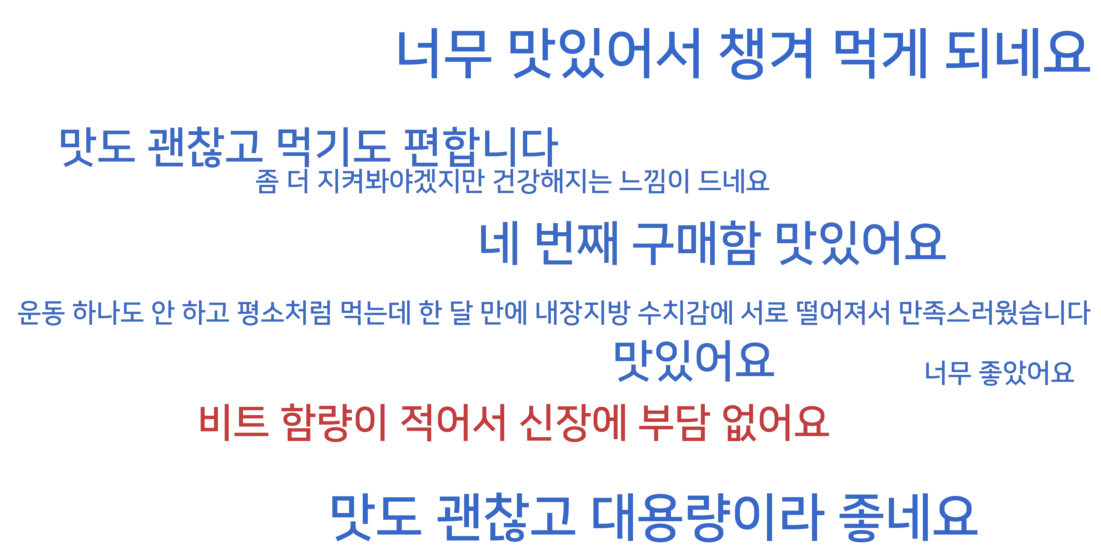

In [150]:
array = wordcloud.to_array()
plt.figure(figsize=(20,10))
plt.imshow(array, interpolation="bilinear")
plt.axis("off")
plt.show()

### KeywordMap

In [80]:
from networkx.drawing.nx_pydot import graphviz_layout
import networkx as nx

In [82]:
custom_vocab = {'콤달콤' : '새콤달콤', '콤_달콤하다' : '새콤달콤하다', '너_미인' : '이너미인', '콤_달달' : '새콤달달', '성_바이오' : '성이바이오', '레모' : '레모나',
               '양제_이다' : '영양제_이다', '고려_은' : '고려은단', '피곤하다_때' : '피곤할 때', '아르_오일' : '아르간 오일', '아르_오일이' : '아르간 오일'}

In [83]:
except_vocabs = list(total_alpha_dict.keys())

In [84]:
token_coocur = [[k for k, _ in review] for review in bad_alpha_list]
token_coocur.extend([[k for k, _ in review] for review in good_alpha_list])

In [85]:
corpus = []
for review in tqdm(token_coocur):
    corpus.append(get_tokens(' '.join(review), except_vocabs))

In [86]:
bigram = Phrases(corpus, min_count=1)
trigram = Phrases(bigram[corpus], min_count=1)

In [87]:
node_weights = dict()
for subject_name, al in total_alpha_dict.items():
    good_al, bad_al = al
    token_coocur = get_token_coocur(good_al + bad_al)
    for review in token_coocur:
        node_weights[(subject_name, review[0])] = node_weights.get((subject_name, review[0]), 0) + 1
        if len(review)>1:
            for i in range(len(review)-1):
                node_weights[(review[i], review[i+1])] = node_weights.get((review[i], review[i+1]), 0) + 1

In [88]:
max_nodes = 100

In [89]:
node_weights = {k:v for k, v in node_weights.items() if v >= 5}
node_weights = dict(sorted(node_weights.items(), key=lambda x:x[1], reverse=True)[:max_nodes])

In [90]:
node_names = list()
for pair in list(node_weights.keys()):
    node_names.extend(list(pair))
node_names = list(set(node_names))

In [ ]:
G1 = nx.Graph()
subject_nodes = [keyword for keyword in total_alpha_dict.keys()]
G1.add_nodes_from(subject_nodes)
G2 = nx.Graph()
for keyword_pair, weight in node_weights.items():
    a, b = keyword_pair
    if a not in subject_nodes:
        G2.add_node(a)
    if b not in subject_nodes:
        G2.add_node(b)
    G2.add_edge(a, b, weight=weight)
    
pos = nx.nx_agraph.pygraphviz_layout(nx.compose_all([G1, G2]))

plt.figure(figsize=(32, 24))
plt.axis('off')

nx.draw_networkx_nodes(G2, pos, nodelist=[node for node in node_names if node not in subject_nodes],
                       node_shape='s', node_size=3000, node_color='#1288e3')
nx.draw_networkx_edges(G2, pos, style='dashed')
nx.draw_networkx_labels(G2, pos, labels={nodename : nodename for nodename in node_names if nodename not in subject_nodes},
                        font_family=fontprop.get_name(), font_size=15)
nx.draw_networkx_nodes(G1, pos, node_shape='h', nodelist=subject_nodes, node_size=6000, node_color='#cc6612')
nx.draw_networkx_labels(G1, pos, font_family=fontprop.get_name(), font_weight='bold', font_size=20)
plt.show()